In [2]:
%matplotlib inline
from pynq.pmods import PMOD_ADC
import numpy as np
import time
import matplotlib.pyplot as plt

def soundAcquisition():
# initialize ADC on PMOD 1 (JB).
# The ADC DA4 has 4 input channels at 12 bit resolution, however only the first 3: 
# V1, V2 and V3 (form 0 to 2) can be used.
# PMOD mapping is: PMOD 1 -> JB, PMOD 2 -> JC, PMOD 3 -> JD, PMOD 4 -> JE
    pmod_adc = PMOD_ADC(1)

# read the tension value for V1 (V1 -> 0) and print it
#value = pmod_adc.read(0)
#print("Current voltage: " + str(value) + "V")

# start logging on V3 (V3 -> 2) with log interval of 1 ms
# NOTE: the current driver allows to log only one input at a time,
# to get data from multiple inputs at the same time you need to get them manually within a loop
#2 è IL CANALE DI LETTURA , 10 INTERVALLO TRA OGNI CAMPIONE(ms)
    pmod_adc.start_log(2, 10)

# TEMPO DI ACQUISIZIONE

    time.sleep(5)

# get and stop logging
    values = pmod_adc.get_log()

# draw graph
    plt.plot(range(len(values)), values, 'r')
    plt.plot([0,len(values)],[0.35,0.35],'b')
    plt.title('ADC data')
    plt.show()
    np.savetxt("RussataNew.npy",values)

In [3]:
%matplotlib inline
import pandas as pd
from pynq.pmods import Grove_Haptic_Motor

def snoreAnalysis(russata):
    hapticMotor = Grove_Haptic_Motor(4, 4)
    media=pd.rolling_mean(russata,50)
    t=np.arange(0,len(russata)*5,5)
    russamento=False
    count=0
    for i in range(len(media)):
        if media[i]>0.5 and media[i-1]<=0.5: #soglia sperimentale
            print("Hai russato al tempo "+str(i/100)+" secondi.")
            count=count+1
            russamento=True

    if count>=2:
        hapticMotor.play_sequence([70])

    plt.plot(t,media)
    plt.title('Moving average signal')
    plt.show()

In [4]:
%matplotlib inline
from pynq.pmods import Grove_IMU
# initialize Grove IMU on PMOD 1 (JB) and grove id 4 (GR4).
# PMOD mapping is: PMOD 1 -> JB, PMOD 2 -> JC, PMOD 3 -> JD, PMOD 4 -> JE
# NOTE: only GR4 can be used for the Grove IMU
imu = Grove_IMU(3,4)
imu2 = Grove_IMU(2,4)

def pitchAcquisition():
    accX=list()
    accY=list()
    accZ=list()
    pitch_l=list()

    accX2=list()
    accY2=list()
    accZ2=list()
    pitch_l2=list()
    while(True):
        try:

            start=time.time()
            # get data from accelerometer
            accl = imu.get_accl()
            accl2 = imu2.get_accl()

            #calculate pitch from accelerations
            argomento= accl[1]/np.sqrt(accl[0]*accl[0]*accl[1]*accl[1])
            argomento2= accl2[1]/np.sqrt(accl2[0]*accl2[0]*accl2[1]*accl2[1])
            pitch = np.arctan(argomento)
            pitch2 = np.arctan(argomento2)

            accX.append(accl[0])
            accY.append(accl[1])
            accZ.append(accl[2])
            pitch_l.append(pitch)

            accX2.append(accl2[0])
            accY2.append(accl2[1])
            accZ2.append(accl2[2])
            pitch_l2.append(pitch2)

            time.sleep(0.05)

        except KeyboardInterrupt:
            # exit without showing errors if the stop button in Jupyter is pressed
            end=time.time()

            break

    np.savetxt("pillowNew.npy",pitch_l)
    np.savetxt("pillowNew2.npy",pitch_l2)

In [20]:
%matplotlib inline
from numpy.fft import rfft, irfft

def CCR (dati,wnd):
    
    template=wnd.tolist()  

    #Zero padding

    for i in range(len(dati)-len(wnd)):
        template.append(0)

    # Fast Fourier Transform (FFT)
    datiFFT= rfft(dati)

    # Inverto il vettore template
    tempY = []
    while len(template) > 0:
        tempY.append(template.pop())

    Y = rfft(tempY)

    # Faccio la formula inversa della FFT

    CrossCorrelazione = irfft(datiFFT*Y)
    a=len(dati)
    if len(tempY)!=len(CrossCorrelazione):
        a=len(dati)-1

    plt.plot(np.arange(a),CrossCorrelazione)
    plt.title("CrossCorrelation")
    plt.xlabel("Samples")
    plt.ylabel("CrossCorrelation")

    plt.show()

    return(CrossCorrelazione)

In [6]:
%matplotlib inline
 
import math

def movementAnalysis(DX,SX):
    for i in range(len(DX)):
        if math.isnan(DX[i]):
            DX[i]=DX[i-1]

    for i in range(len(SX)):
        if math.isnan(SX[i]):
            SX[i]=SX[i-1]

    #cross-correlazione del template con il segnale generico

    corrdx=CCR(DX,wnd_dx)

    corrsx=CCR(SX,wnd_sx)

    print("Each peak represent a movement during sleep. A stable signal means a quiet sleep.")

In [ ]:
from IPython import display
while(True):
    try:
        soundAcquisition()
        pitchAcquisition()
        snoring=np.loadtxt("RussataNew.npy")
        snoreAnalysis(snoring)
        wnd_dx=np.loadtxt("finestra_destra_basso.npy")
        wnd_sx=np.loadtxt("finestra_sinistra_basso.npy")
        dataDx=np.loadtxt("pillowNew.npy")
        dataSx=np.loadtxt("pillowNew2.npy")
        movementAnalysis(dataDx,dataSx)

        
    except KeyboardInterrupt:
            # exit without showing errors if the stop button in Jupyter is pressed
            break


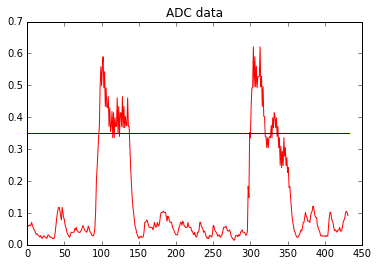

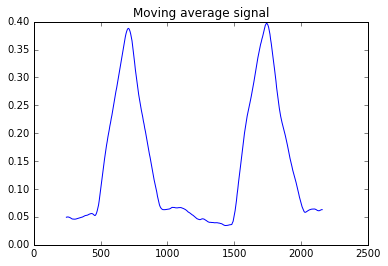

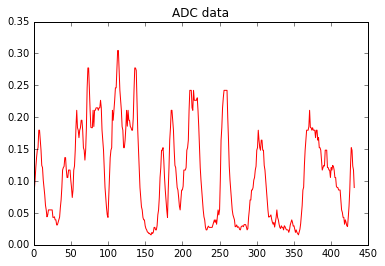

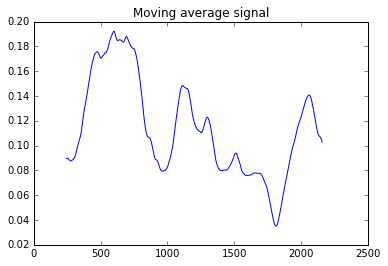

In [21]:
from IPython import display
while(True):
    try:
        soundAcquisition()
        snoring=np.loadtxt("RussataNew.npy")
        snoreAnalysis(snoring)
        
    except KeyboardInterrupt:
            # exit without showing errors if the stop button in Jupyter is pressed
            break

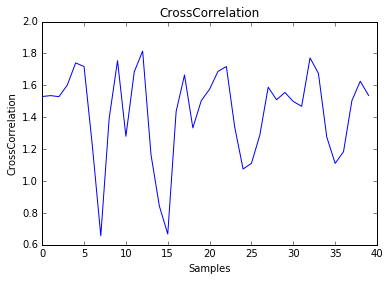

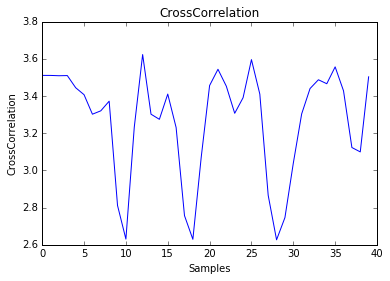

In [ ]:
from IPython import display
while(True):
    try:
        pitchAcquisition()
        wnd_dx=np.loadtxt("finestra_destra_basso.npy")
        wnd_sx=np.loadtxt("finestra_sinistra_basso.npy")
        dataDx=np.loadtxt("pillowNew.npy")
        dataSx=np.loadtxt("pillowNew2.npy")
        movementAnalysis(dataDx,dataSx)
    except KeyboardInterrupt:
            # exit without showing errors if the stop button in Jupyter is pressed
            break